In [1]:
# graphs are incorporated into the notebook 
%pylab inline                 

style.use('ggplot')           # more stylish plots
style.use('seaborn-muted')    # better default line colors

Populating the interactive namespace from numpy and matplotlib


In [2]:
# division of two integers will return float
from __future__ import division

In [100]:
# compiled functions for some code speedup
from numba import autojit

In [101]:
# spline interpolation for smooth stimulation currents
from scipy.interpolate import UnivariateSpline as usp

In [295]:
def izhikevich_neuron(vr=-60,vt=-40,a=0.03,b=-2,c=-50,d=100,vpeak=35,k=0.7,C=100):
    def rhs_(state,t,I=0):
        v,u = state
        dv = (k*(v-vr)*(v-vt) - u + I)/C
        du = a*(b*(v-vr)-u)
        return array((dv,du))
    def reset_(state):
        v,u = state
        resetted = False
        if v >= vpeak:
            v = c
            u = u+d
            #state[:] = v,u
            resetted = True
            state[0]  = vpeak
        return array((v,u)),resetted
    return rhs_, reset_
        

In [296]:
params1 = dict(C=100, vr=-60, vt=-40, k=0.7,a=0.03,b=-2,c=-50,d=100)

In [297]:
nrhs,nreset = izhikevich_neuron(**params1)

In [298]:
n([0,0],0)

array([ 16.8,  -3.6])

In [299]:
def I_pulse(tx, amp, start, stop,k=10):
    "Creates single pulse with given amplitude, start and stop times"
    return amp*0.5*(1 + tanh(k*(tx-start)) * tanh(k*(-tx+stop)))

def I_ramp(tx, k, start=50,stop=1000):
    "Creates simple linear ramps to use for stimulations"
    #return  k*(tx-start)*I_pulse(tx, 1, start, stop)
    return usp(tx, k*(tx-start)*I_pulse(tx, 1, start, stop),s=0)


def make_pulses(tv, npulses=5, period=5, start=100, amp=5, width=1,steep=10.):
    "Creates a set of pulses for stimulation currents"
    onsets = arange(start, start+npulses*period,period)
    y = np.sum(I_pulse(tv, amp, on, on+width,k=steep) for on in onsets)
    return usp(tv, y, s=0)

def combine_interpolations(tv, signals):
    "Merges several interpolated signals into one interpolation"
    y = np.sum(s(tv) for s in signals)
    return usp(tv, y, s=0)


In [375]:
def simple_integrate_n(rhs, resetter, init_state, dt=0.5, tstart=0, tstop=500, Idyn=None):
    """Simple function to integrate a set of ODEs
    Inputs:
       rhs : callable, calculates right-hand sides of ODEs
       init_state: initial state as a 1D vector
       dt : fixed time step
       tstart: time at start of integration
       tsopt: integrate until this time
       fnkwargs: dictionary with optional parameters for the rhs function
    """
        
    ndim = len(init_state)
    tv = arange(tstart,tstop,dt)
    xout = zeros((len(tv), ndim))
    xout[0] = init_state
    if Idyn is None:
        def Idyn(t):
            return 0
        
    
    fprev = array(rhs(xout[0], tv[0],Idyn(tstart)))
    xnew = xout[0] + dt*fprev
    xout[1] = xnew
    resetted = False
    
    k = 1
    t = 0
    while t < tstop and k < len(tv)-1:
        xcurr = xout[k]
        
        fnew = array(rhs(xcurr, t,Idyn(t)))
        if resetted:
            xnew = xcurr + dt*fnew
        else:
            xnew = xcurr + 0.5*dt*(3*fnew - fprev)
        fprev = fnew
        
        xnew2, resetted = resetter(xnew)
        if resetted:
            xout[k+1] = xnew
            xnew = xnew2
            k += 1
            t += dt
        xout[k+1] = xnew
        k+=1
        t+=dt
    return tv, xout

In [376]:
Ilongp = make_pulses(arange(1000),npulses=1,start=100,amp=70, width=1000)
#%timeit(Ilongp(arange(1000)))
#plot(arange(1000),Ilongp(arange(1000)))

In [377]:
%time tv,traj = simple_integrate_n(nrhs,nreset,(-60,0),dt=0.25,tstop=1000,Idyn=Ilongp)

CPU times: user 92 ms, sys: 0 ns, total: 92 ms
Wall time: 90.7 ms


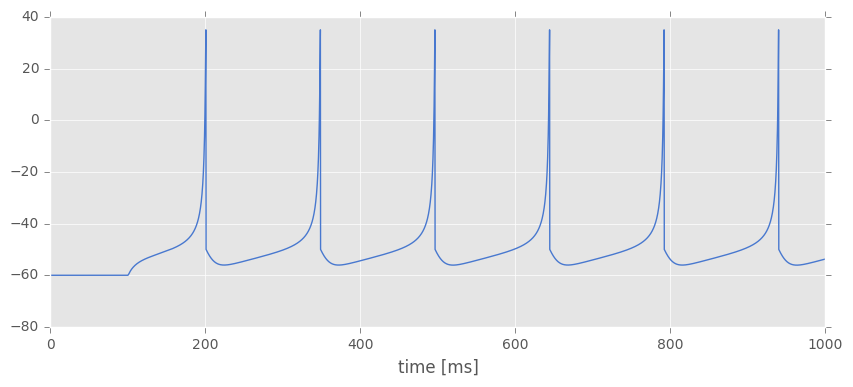

In [378]:
figure(figsize=(10,4))
plot(tv, traj[:,0])
#xlim(100,250)
xlabel('time [ms]')

In [379]:
ti = find(abs(traj[:,0]-35)<0.1)
ti
traj[ti]

array([[ 35.        , -37.82202649],
       [ 35.        , -37.73489094],
       [ 35.        , -37.45927234],
       [ 35.        , -37.81287497],
       [ 35.        , -37.70545302],
       [ 35.        , -37.36845216]])

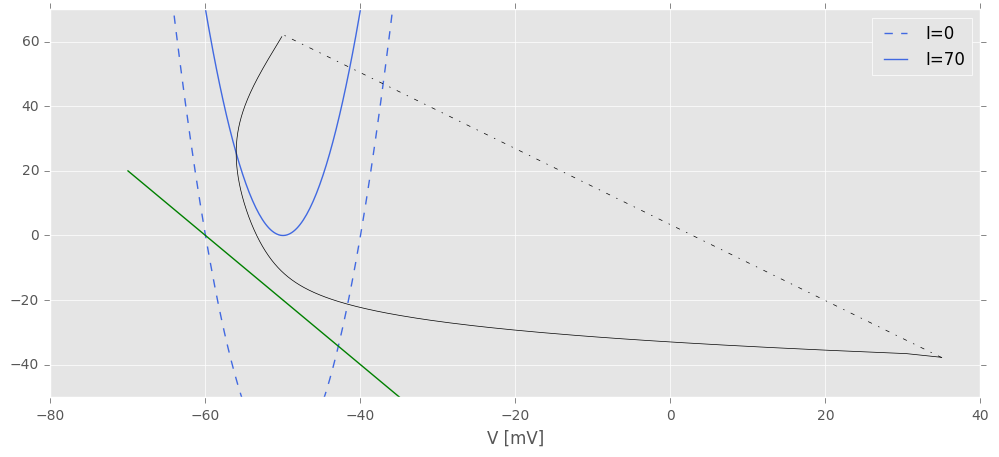

In [380]:
# Figure 8.6b Izhikevich

figure(figsize=(12,5))
vnull = lambda v,p,I=0: p['k']*(v-p['vr'])*(v-p['vt']) + I
unull = lambda v,p: p['b']*(v-p['vr'])

v = linspace(-70, 35.5,500)

plot(v,vnull(v,params1),'--',color='royalblue',label='I=0')
plot(v,vnull(v,params1,70),'-',color='royalblue',label='I=70')

plot(v,unull(v,params1),color='g')

plot(traj[ti[0]:ti[0]+2,0],traj[ti[0]:ti[0]+2,1],'k-.',lw=0.5)
plot(traj[ti[0]+2:ti[1]+1,0],traj[ti[0]+2:ti[1]+1,1],'k-',lw=0.5)

legend()
ylim(-50,70)
xlabel('V [mV]')

## Models of cortical neurons

### Regular spiking

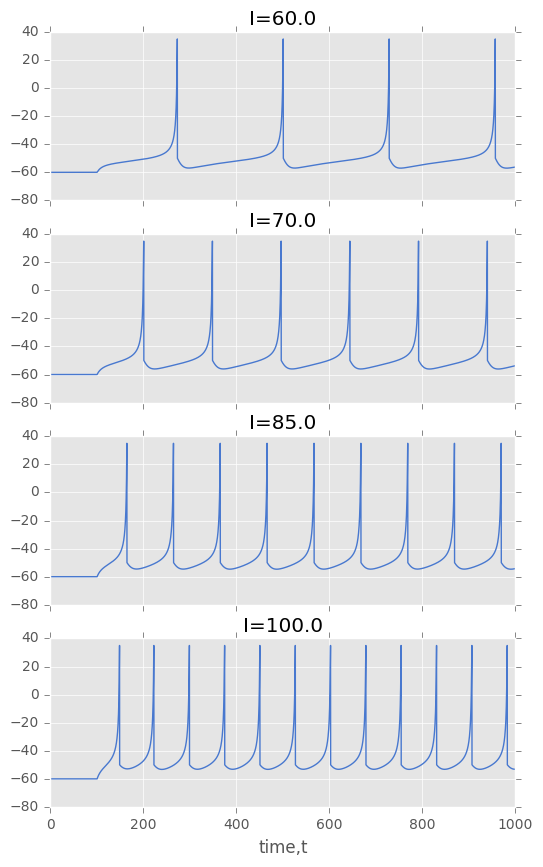

In [391]:
params_rs = dict(vr=-60, vt=-40, k=0.7, b=-2, a=0.03, vpeak=35,c=-50,d=100,C=100)

n_rs = izhikevich_neuron(**params_rs)
tv = arange(1000)


f, axs = subplots(4,1,sharex=True,sharey=True,figsize=(6,10))

for ax,amp in zip(axs, (60,70,85,100)):

    tv,traj = simple_integrate_n(*n_rs,init_state=(-60,0),dt=0.25,tstop=1000,
                                 Idyn=make_pulses(tv,npulses=1, start=100,width=1000,amp=amp))
    ax.plot(tv,traj[:,0])
    ax.set_title('I=%0.1f'%amp)
xlabel('time,t')

### Intrinsically Bursting

#### Single-compartment

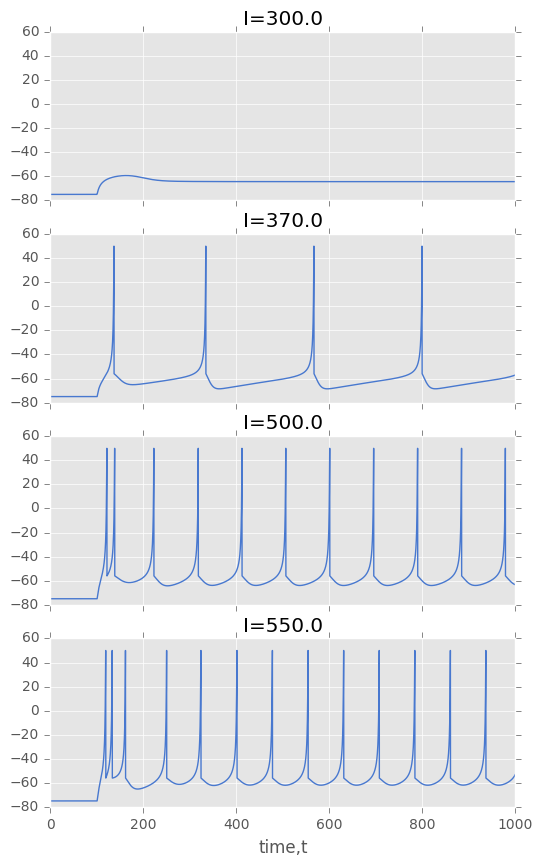

In [394]:
params_ib1 = dict(C=150, k=1.2, vr=-75, vt=-45, a=0.01, vpeak=50, b=5,c=-56, d=130)

n_ib = izhikevich_neuron(**params_ib1)
tv = arange(1000)


f, axs = subplots(4,1,sharex=True,sharey=True,figsize=(6,10))

for ax,amp in zip(axs, (300,370,500,550)):

    tv,traj = simple_integrate_n(*n_ib,init_state=(-75,0),dt=0.25,tstop=1000,
                                 Idyn=make_pulses(tv,npulses=1, start=100,width=1000,amp=amp))
    ax.plot(tv,traj[:,0])
    ax.set_title('I=%0.1f'%amp)
xlabel('time,t')

#### Soma-dendrite model

In [ ]:
def izhikevich_neuron(vr=-60,vt=-40,a=0.03,b=-2,c=-50,d=100,vpeak=35,k=0.7,C=100):
    def rhs_(state,t,I=0):
        v,u = state
        dv = (k*(v-vr)*(v-vt) - u + I)/C
        du = a*(b*(v-vr)-u)
        return array((dv,du))
    def reset_(state):
        v,u = state
        resetted = False
        if v >= vpeak:
            v = c
            u = u+d
            #state[:] = v,u
            resetted = True
            state[0]  = vpeak
        return array((v,u)),resetted
    return rhs_, reset_

In [398]:
def soma_dendrite(C=[150,30], vr=[-70, -50], vt=[-45, 0], k=[3,1], 
                  a=[0.01,3], b=[5, 15], c=[-52, -20],
                  vpeak=[50,20],d=[240,500]):
    def rhs_(state,t,I):
        vs,us,vd,ud=state
        dvs = (k[0]*(vs-vr[0])*(vs-vt[0]) + 50*(vd-vs) - us + I)/C[0]
        dus = a[0]*(b[0]*(vs-vr[0])-us)
        
        dvd = ((vd-vr[1])**2 + 20*(vs-vd) - ud)/C[1]
        dud = a[1]*(b[1]*(vd-vr[1]) - ud)
        return array((dvs,dus,dvd,dud))
    def reset_(state):
        vs,us,vd,ud=state
        resetted = False
        if vs > vpeak[0]:
            state[0] = vpeak[0]
            vs = c[0]
            us = us + d[0]
            resetted=True
        if vd > vpeak[1]:
            state[2] = vpeak[1]
            vd = c[1]
            ud = ud + d[1]
            resetted=True
        return array((vs,us,vd,ud)),resetted
    return rhs_, reset_

In [410]:

tv,traj = simple_integrate_n(*soma_dendrite(),init_state=(-70,0,-50,0),dt=0.25,tstop=2000,
                                 Idyn=make_pulses(arange(10000),npulses=1, start=100,width=10000,amp=560))

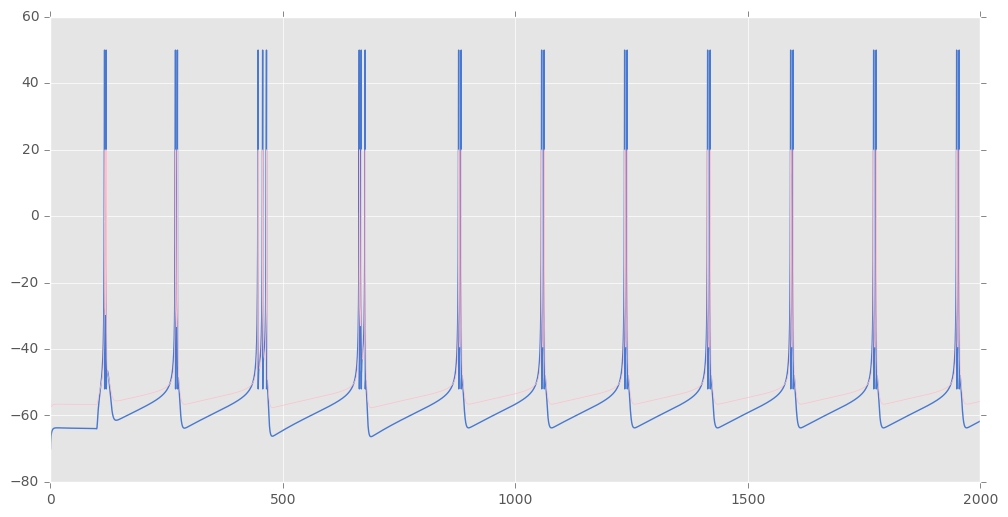

In [413]:
figure(figsize=(12,6))

plot(tv,traj[:,0])
plot(tv,traj[:,2],color='pink',lw=0.5)

(1000, 1200)

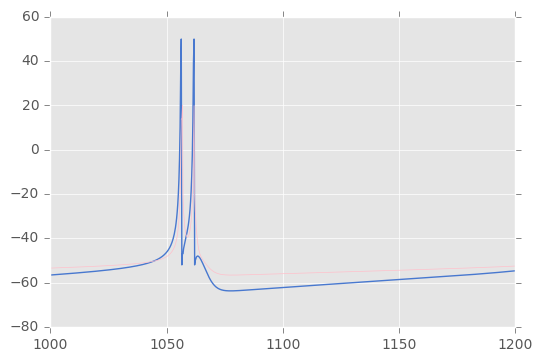

In [414]:
plot(tv,traj[:,0])
plot(tv,traj[:,2],color='pink',lw=0.5)
xlim(1000,1200)